In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

from config import NUM_CLASSES

2023-04-18 04:26:19.953747: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 04:26:20.100442: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-18 04:26:20.869468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-18 04:26:20.869570: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not lo

In [3]:
from dataset import Dataset

dataset = Dataset()

2023-04-18 04:26:21.886207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 04:26:22.565389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15391 MB memory:  -> device: 0, name: NVIDIA Tesla P100-SXM2-16GB, pci bus id: 0000:07:00.0, compute capability: 6.0


In [4]:
import numpy as np
from skeleton_graph import tssi_v2

joints_order = tssi_v2()[1]

print(len(np.unique(joints_order)))
print(len(joints_order))

unique_joints = list(np.unique(joints_order))

unique_idxs = [joints_order.index(j) for j in unique_joints]

len(unique_idxs)

68
135


68

In [5]:
def reshape_dataset(x, y):
    # x.shape -> (batch_size, length, joints, coordinates)
    # x = tf.gather(x, unique_idxs, axis=2)
    # x = tf.keras.layers.Reshape([60, -1])(x)
    # y_new = tf.keras.layers.Reshape([1, -1])(y)
    # return (x, y_new), y
    return x, y

train_dataset = dataset.get_training_set(
    batch_size=64,
    buffer_size=dataset.num_train_examples,
    repeat=False,
    deterministic=True,
    augmentation=False,
    pipeline="default")
# train_dataset = train_dataset.map(reshape_dataset)

validation_dataset = dataset.get_validation_set(
    batch_size=64,
    pipeline="default")
# validation_dataset = validation_dataset.map(reshape_dataset)

In [6]:
for examples, en_labels in train_dataset.take(1):
    pt = examples
    en = tf.keras.layers.Reshape([1, -1])(en_labels)
    break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 32, 135, 2)
(64, 1, 250)
(64, 250)


In [7]:
INPUT_FEATURES_LENGTH = pt.shape[2]

In [8]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

In [9]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        # original -> self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    # def compute_mask(self, *args, **kwargs):
    #     return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        # x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [10]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [11]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [12]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [13]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        # attn_output = self.mha(
        #     query=x,
        #     value=x,
        #     key=x,
        #     use_causal_mask = True)
        # x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [14]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [15]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [16]:
from keras_nlp.layers import PositionEmbedding

class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    # original -> self.pos_embedding = PositionalEmbedding(d_model=d_model)
    self.pos_embedding = PositionEmbedding(sequence_length=60)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    # x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    
    # added for positionembedding
    position_embeddings = self.pos_embedding(x)
    x = x + position_embeddings

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [17]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [18]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    # x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [68]:
# base

from densenet4transformer import DenseNet121

class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, num_classes,
                 dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               dropout_rate=dropout_rate)

        # self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
        #                        num_heads=num_heads, dff=dff,
        #                        dropout_rate=dropout_rate)

        # input_shape=[60, INPUT_FEATURES_LENGTH, 2]
        self.backbone = DenseNet121(blocks=[6, 12, 24, 16],
                                    pooling="avg",
                                    growth_rate=4,
                                    attention=None,
                                    dropout=0.1)

        self.final_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
        # self.class_query = tf.Variable(tf.random.uniform(shape=[1, d_model]))
        self.inner_reshape = tf.keras.layers.Reshape([32, d_model])

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        # context, x  = inputs
        context = inputs

        # Embed with DenseNet
        context = self.backbone(context) # (batch_size, new_len, d_model, 1)
        
        # Reshape embedding
        context = self.inner_reshape(context) # (batch_size, new_len, d_model)

        # Encode embedding
        context = self.encoder(context)  # (batch_size, new_len, d_model)

        # Decode with class query
        # x = tf.expand_dims(tf.repeat(self.class_query, tf.shape(context)[0], axis=0), axis=1)
        # x = self.decoder(x, context)  # (batch_size, target_len, d_model)
        
        x = tf.keras.layers.GlobalAveragePooling1D()(context)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        # return logits[:, 0, :]
        return logits

    def make(self, input_shape=[60, INPUT_FEATURES_LENGTH, 2], name="transformer_v5"):
        '''
        This method makes the command "model.summary()" work.
        input_shape: (H,W,C), do not specify batch B
        '''
        x = tf.keras.layers.Input(shape=input_shape)
        model = tf.keras.Model(inputs=[x], outputs=self.call(x), name=name)
        return model

In [20]:
num_layers = 4
d_model = 117#INPUT_FEATURES_LENGTH
dff = 2048
num_heads = 9
dropout_rate = 0.1

In [21]:
tf.random.set_seed(0)

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    num_classes=NUM_CLASSES,
    dropout_rate=dropout_rate).make(input_shape=[32, 135, 2])

In [22]:
output = transformer(pt)

print(pt.shape)
print(output.shape)

2023-04-18 04:26:27.362898: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700


(64, 32, 135, 2)
(64, 250)


In [23]:
# attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
# print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

In [24]:
transformer.summary()

Model: "transformer_v5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 135, 2)]      0         
                                                                 
 dense_net121 (DenseNet121)  (None, 32, 117, 1)        73156     
                                                                 
 reshape_1 (Reshape)         (None, 32, 117)           0         
                                                                 
 encoder (Encoder)           (None, 32, 117)           3918800   
                                                                 
 global_average_pooling1d (G  (None, 117)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_8 (Dense)             (None, 250)               29500     
                                                    

In [25]:
from optimizer import build_sgd_optimizer

optimizer, lr_sched = build_sgd_optimizer(initial_learning_rate=0.0008,
                                maximal_learning_rate=0.008,
                                momentum=0.98,
                                nesterov=True,
                                step_size=1181 * 15,
                                weight_decay=1e-6,
                                return_lr_schedule=True)

transformer.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='top_1', dtype=tf.float32)])

Text(0.5, 0, 'Train Step')

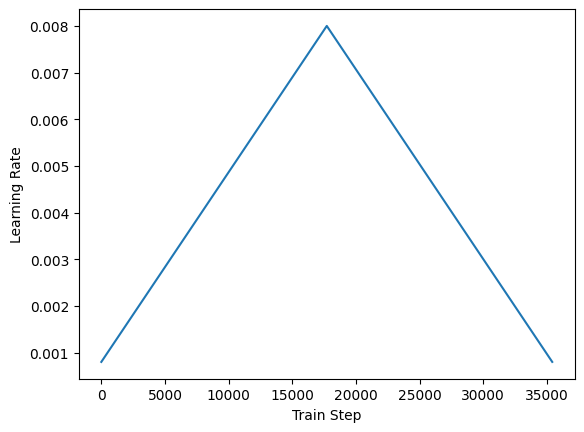

In [26]:
plt.plot(lr_sched(tf.range(1181 * 30, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [27]:
transformer.fit(train_dataset,
                epochs=30,
                validation_data=validation_dataset)

Epoch 1/30
1181/1181 [==============================] - 88s 71ms/step - loss: 5.3362 - top_1: 0.0135 - val_loss: 4.8227 - val_top_1: 0.0435
Epoch 2/30
1181/1181 [==============================] - 78s 66ms/step - loss: 3.9379 - top_1: 0.1381 - val_loss: 3.1364 - val_top_1: 0.2564
Epoch 3/30
1181/1181 [==============================] - 78s 66ms/step - loss: 2.8928 - top_1: 0.3001 - val_loss: 2.4961 - val_top_1: 0.3742
Epoch 4/30
1181/1181 [==============================] - 78s 66ms/step - loss: 2.4316 - top_1: 0.3902 - val_loss: 2.1952 - val_top_1: 0.4408
Epoch 5/30
1181/1181 [==============================] - 78s 66ms/step - loss: 2.1422 - top_1: 0.4511 - val_loss: 2.0738 - val_top_1: 0.4616
Epoch 6/30
1181/1181 [==============================] - 78s 66ms/step - loss: 1.9549 - top_1: 0.4898 - val_loss: 1.8326 - val_top_1: 0.5233
Epoch 7/30
1181/1181 [==============================] - 78s 66ms/step - loss: 1.7986 - top_1: 0.5288 - val_loss: 1.8429 - val_top_1: 0.5250
Epoch 8/30
1181/1181

In [28]:
transformer.evaluate(validation_dataset)

507/507 [==============================] - 8s 15ms/step - loss: 1.1665 - top_1: 0.7861


[1.166501522064209, 0.7861452102661133]

In [29]:
transformer.save_weights("transformer_v5.h5")

# Convert to TF Model Lite

In [69]:
transformer2 = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    num_classes=NUM_CLASSES,
    dropout_rate=dropout_rate).make(input_shape=[32, 135, 2], name="outputs")
transformer2.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='top_1', dtype=tf.float32)])

In [70]:
transformer2.load_weights("transformer_v5.h5")

In [71]:
transformer2.evaluate(validation_dataset)

507/507 [==============================] - 9s 15ms/step - loss: 1.1665 - top_1: 0.7861


[1.166501522064209, 0.7861452102661133]

In [77]:
import tensorflow as tf
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras import Input
from tensorflow.keras.models import Model

from preprocessing import ResizeIfMoreThan, PadIfLessThan, OneItemBatch, FillNaNValues, RemoveZ, OneItemUnbatch, AddRoot, SortColumns
from tensorflow.keras.layers import Reshape
from skeleton_graph import tssi_v2
from loss import select_loss

NUM_CLASSES = 250
TSSI_ORDER = tssi_v2()[1]

preprocessing_pipeline = tf.keras.Sequential([
    OneItemBatch(),
    RemoveZ(),
    FillNaNValues(),
    AddRoot(),
    SortColumns(tssi_order=TSSI_ORDER),
    ResizeIfMoreThan(frames=32),
    PadIfLessThan(frames=32),
    Reshape((32, 135, 2))
])

def build_mobile_model(input_shape=[543, 3],
                       optimizer=None,
                       use_loss="crossentropy"):
    # ORIGINAL INPUT SHAPE = [frames, 543, 3]
    inputs = Input(shape=input_shape, name="inputs")

    # PREPROCESSING
    x = preprocessing_pipeline(inputs)

    # SET CORRECT INPUT SHAPE
    # backbone = Transformer(
    #     num_layers=num_layers,
    #     d_model=d_model,
    #     num_heads=num_heads,
    #     dff=dff,
    #     num_classes=NUM_CLASSES,
    #     dropout_rate=dropout_rate).make(input_shape=[32, 135, 2], name="outputs")
    predictions = transformer2(x)

    # REORDER PREDICTIONS
    # predictions = ReorderLayer(class_idxs, name="outputs")(predictions)

    model = Model(inputs=inputs, outputs=predictions)

    # setup the metrics
    metrics = [
        TopKCategoricalAccuracy(k=1, name='top_1', dtype=tf.float32)
    ]

    # setup the loss
    loss = select_loss(use_loss)

    # compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # LOAD WEIGHTS
    # model.load_weights("transformer_v5.h5")

    return model

In [78]:
mobile_model = build_mobile_model(optimizer=optimizer)

In [79]:
mobile_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 543, 3)]          0         
                                                                 
 sequential_30 (Sequential)  (1, 32, 135, 2)           0         
                                                                 
 outputs (Functional)        (None, 250)               4021456   
                                                                 
Total params: 4,021,456
Trainable params: 4,021,006
Non-trainable params: 450
_________________________________________________________________


In [80]:
%timeit mobile_model.predict(tf.zeros([100, 543, 3]))

4/4 [==============================] - 0s 4ms/step
75.6 ms ± 4.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [81]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(mobile_model)
tflite_model = converter.convert()

# Save the model.
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpwegzs4vf/assets


INFO:tensorflow:Assets written to: /tmp/tmpwegzs4vf/assets
2023-04-18 05:32:26.176837: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-18 05:32:26.176902: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-18 05:32:26.177108: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwegzs4vf
2023-04-18 05:32:26.212318: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-18 05:32:26.212355: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwegzs4vf
2023-04-18 05:32:26.312979: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-04-18 05:32:26.548631: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwegzs4vf
2023-04-18 05:32:26.646705: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [82]:
import numpy as np
import tflite_runtime.interpreter as tflite
interpreter = tflite.Interpreter("tflite/model.tflite")

found_signatures = list(interpreter.get_signature_list().keys())

prediction_fn = interpreter.get_signature_runner("serving_default")
output = prediction_fn(inputs=tf.zeros([100, 543, 3]))
sign = np.argmax(output["outputs"])
print(sign)

211


In [83]:
%timeit prediction_fn(inputs=tf.zeros([100, 543, 3]))

24.4 ms ± 650 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
